In [1]:
import importlib
from pathlib import Path

import h5py
import logomaker as lm
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyBigWig
import seaborn as sns
import tensorflow as tf
from matplotlib.patches import ConnectionPatch
from Modules import plot_utils, utils
from scipy.stats import pearsonr
from tensorflow.keras import backend as K

2024-09-16 10:57:55.504035: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]

In [3]:
def correlate(y_true, y_pred):
    """
    Calculate the correlation between the predictions and the labels.

    :Example:

    >>> model.compile(optimizer = 'adam', losses = correlate)
    >>> load_model('file', custom_objects = {'correlate : correlate})
    """
    X = y_true - K.mean(y_true)
    Y = y_pred - K.mean(y_pred)

    sigma_XY = K.sum(X * Y)
    sigma_X = K.sqrt(K.sum(X * X))
    sigma_Y = K.sqrt(K.sum(Y * Y))

    return sigma_XY / (sigma_X * sigma_Y + K.epsilon())


def mae_cor(y_true, y_pred):
    """
    Calculate the mean absolute error minus the correlation between
    predictions and  labels.

    :Example:

    >>> model.compile(optimizer = 'adam', losses = mae_cor)
    >>> load_model('file', custom_objects = {'mae_cor : mae_cor})
    """
    X = y_true - K.mean(y_true)
    Y = y_pred - K.mean(y_pred)

    sigma_XY = K.sum(X * Y)
    sigma_X = K.sqrt(K.sum(X * X))
    sigma_Y = K.sqrt(K.sum(Y * Y))

    cor = sigma_XY / (sigma_X * sigma_Y + K.epsilon())
    mae = K.mean(K.abs(y_true - y_pred))

    return 1 + mae - cor


In [4]:
model_nuc_name = "model_myco_nuc_2"
model_nuc = tf.keras.models.load_model(
    f"/home/alex/shared_folder/SCerevisiae/Trainedmodels/{model_nuc_name}/model",
    custom_objects={"correlate": correlate, "mae_cor": mae_cor},
)
model_pol_name = "model_myco_pol_17"
model_pol = tf.keras.models.load_model(
    f"/home/alex/shared_folder/SCerevisiae/Trainedmodels/{model_pol_name}/model",
    custom_objects={"correlate": correlate, "mae_cor": mae_cor},
)
model_coh_name = "model_myco_coh_14"
model_coh = tf.keras.models.load_model(
    f"/home/alex/shared_folder/SCerevisiae/Trainedmodels/{model_coh_name}/model",
    custom_objects={"correlate": correlate, "mae_cor": mae_cor},
)

2024-09-16 10:37:43.285376: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-09-16 10:37:43.358423: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-16 10:37:43.358611: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2024-09-16 10:37:43.358659: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-16 10:37:43.358774: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID

In [4]:
with np.load(
    f"/home/alex/shared_folder/SCerevisiae/results/model_myco_nuc_2/preds_on_W303_Mmmyco.npz"
) as f:
    preds_nuc = {k: f[k] for k in f.keys()}
with np.load(
    f"/home/alex/shared_folder/SCerevisiae/results/model_myco_pol_17/preds_mid_on_W303_Mmmyco.npz"
) as f:
    preds_pol = {k: f[k] for k in f.keys()}
with np.load(
    f"/home/alex/shared_folder/SCerevisiae/results/model_myco_coh_14/preds_on_W303_Mmmyco.npz"
) as f:
    preds_coh = {k: f[k] for k in f.keys()}

with np.load("/home/alex/shared_folder/SCerevisiae/genome/W303_Mmmyco.npz") as f:
    one_hots_myco = {k: f[k] for k in f.keys()}
list(one_hots_myco.keys())

['chrI',
 'chrII',
 'chrIII',
 'chrIV',
 'chrV',
 'chrVI',
 'chrVII',
 'chrVIII',
 'chrIX',
 'chrX',
 'chrXI',
 'chrXII',
 'chrXIII',
 'chrXIV',
 'chrXV',
 'chrXVI',
 'Mmmyco']

In [5]:
def get_gradients(
    model, one_hots, batch_size=1024, predict=False, output_idx=0, proj=["simplex"]
):
    grads = np.empty(one_hots.shape, dtype="float32")
    n_batches = int(np.ceil((len(one_hots) / batch_size)))
    for i in range(n_batches):
        batch_start, batch_stop = i * batch_size, (i + 1) * batch_size
        X = tf.Variable(one_hots[batch_start:batch_stop], dtype=tf.float32)
        with tf.GradientTape() as tape:
            Y = model(X, training=False)
            if output_idx is not None:
                Y = Y[..., output_idx]
        grads[batch_start:batch_stop] = np.array(tape.gradient(Y, X))
        if predict:
            Y = np.array(Y)
            if i == 0:
                preds = np.empty((len(one_hots),) + Y.shape[1:], dtype="float32")
            preds[batch_start:batch_stop] = Y
    if "simplex" in proj:
        grads -= grads.sum(axis=-1, keepdims=True)
    if "sequence" in proj:
        grads = (grads * one_hots).sum(axis=-1)
    if predict:
        return grads, preds
    else:
        return grads


def mutasome_by_pos(model, one_hot, pos, WINDOW, pred):
    # tested for WINDOW 2001 and model with single output
    mutascores = []
    for incr in range(3):
        if np.all(one_hot[pos] == 0):
            mutascore = 0
        else:
            local_one_hot = one_hot[max(0, pos - WINDOW + 1) : pos + WINDOW].copy()
            local_pred = pred[
                max(0, pos - WINDOW + 1) + WINDOW // 2 : pos + WINDOW // 2 + 1
            ]
            local_pos = min(WINDOW - 1, pos)
            # make mutation
            local_one_hot[local_pos] = np.eye(4, dtype=one_hot.dtype)[
                (np.argmax(local_one_hot[local_pos]) + incr) % 4
            ]
            inputs = utils.sliding_window_view(local_one_hot, (WINDOW, 4)).reshape(
                -1, WINDOW, 4
            )
            mut_pred = np.array(
                model(tf.convert_to_tensor(inputs, dtype=float))
            ).squeeze(axis=-1)
            # compute mse
            mutascore = np.mean((mut_pred - local_pred) ** 2)
            mutascores.append(mutascore)
    return mutascores

In [97]:
model = model_nuc
WINDOW = 2001
original_one_hot = one_hots_myco["chrI"]
original_preds = preds_nuc["chrI"]
mutascores = []
for pos in range(10000, 11000):
    mutascores.append(
        mutasome_by_pos(model, original_one_hot, pos, WINDOW, original_preds)
    )
mutascores = np.array(mutascores).reshape(-1, 3)

In [ ]:
model_batch_size = 1024
chr_chunk_size = 200000
model_name = "model_myco_nuc_2"  # "model_myco_pol_17"  #
WINDOW = 2001  # 2048  #
output_idx = 0  # 8  #
chrom = "chrXVI"

genome_file = Path("..", "shared_folder", "SCerevisiae", "genome", "W303_Mmmyco.npz")
model_file = Path(
    "..", "shared_folder", "SCerevisiae", "Trainedmodels", model_name, "model"
)
custom_objects = {"correlate": correlate, "mae_cor": mae_cor}
# output_dir = Path('..', 'shared_folder', 'SCerevisiae', 'results', 'models_etienne', 'saliency')

model = tf.keras.models.load_model(model_file, custom_objects=custom_objects)
with np.load(genome_file) as f:
    for chr_id in f.keys():
        if chr_id != chrom:  # chr_id[:3] == 'chr':
            one_hot = f[chr_id]
        else:
            continue
        print(f"processing {chr_id}")
        one_hots = utils.sliding_window_view(one_hot, (WINDOW, 4)).reshape(
            -1, WINDOW, 4
        )
        n_chunks = int(np.ceil((len(one_hots) / chr_chunk_size)))
        grads = []
        for i in range(n_chunks):
            X = one_hots[chr_chunk_size * i : chr_chunk_size * (i + 1)]
            print(f"\tprocessing chunk {i} of size {len(X)}")
            grads.append(
                get_gradients(model, X, model_batch_size, proj=["simplex", "sequence"])
            )
        full_grads = np.concatenate(grads)
        del grads
        print("\tsaving output file")
        output_file = utils.safe_filename(
            f"/home/alex/shared_folder/SCerevisiae/results/{model_name}/saliency_{model_name}_{chr_id}_onseq.npz"
        )
        np.savez_compressed(output_file, full_grads)
        del full_grads

processing chrI
	processing chunk 0 of size 200000
	processing chunk 1 of size 43675
	saving output file
processing chrII
	processing chunk 0 of size 200000
	processing chunk 1 of size 200000
	processing chunk 2 of size 200000
	processing chunk 3 of size 200000
	processing chunk 4 of size 16518
	saving output file
processing chrIII
	processing chunk 0 of size 200000
	processing chunk 1 of size 145597
	saving output file
processing chrIV
	processing chunk 0 of size 200000
	processing chunk 1 of size 200000
	processing chunk 2 of size 200000
	processing chunk 3 of size 200000
	processing chunk 4 of size 200000
	processing chunk 5 of size 200000
	processing chunk 6 of size 200000
	processing chunk 7 of size 146464
	saving output file
processing chrV
	processing chunk 0 of size 200000
	processing chunk 1 of size 200000
	processing chunk 2 of size 188080
	saving output file
processing chrVI
	processing chunk 0 of size 200000
	processing chunk 1 of size 69173
	saving output file
processing c

In [6]:
model_name = "model_myco_nuc_2"
sumabs_grads_dict = {}
for chrom in one_hots_myco.keys():
    print(chrom)
    with np.load(
        f"/home/alex/shared_folder/SCerevisiae/results/{model_name}/saliency_{model_name}_{chrom}_onseq.npz"
    ) as f:
        grads = f["arr_0"]
    WINDOW = grads.shape[1]
    sumabs_grads = np.zeros(len(grads) + WINDOW - 1)
    for j in range(WINDOW):
        sumabs_grads[j : len(sumabs_grads) - WINDOW + j + 1] += np.abs(grads[:, j])
    del grads
    sumabs_grads /= WINDOW
    sumabs_grads_dict[chrom] = sumabs_grads
    del sumabs_grads
np.savez_compressed(
    f"/home/alex/shared_folder/SCerevisiae/results/{model_name}/saliency_{model_name}_W303_Mmmyco_onseq_sumabs.npz",
    **sumabs_grads_dict,
)

chrI
chrII
chrIII
chrIV
chrV
chrVI
chrVII
chrVIII
chrIX
chrX
chrXI
chrXII
chrXIII
chrXIV
chrXV
chrXVI
Mmmyco


In [13]:
model_name = "model_myco_nuc_2"  # "model_myco_coh_14"  # "model_myco_pol_17"  #
with np.load(
    f"/home/alex/shared_folder/SCerevisiae/results/{model_name}/saliency_{model_name}_W303_Mmmyco_onseq_sumabs.npz"
) as f:
    sumabs_grads_dict = {k: f[k] for k in f.keys()}

In [ ]:
# aligned_grads_onseq = np.zeros((WINDOW, len(full_grads_onseq) + WINDOW - 1))
# for j in range(WINDOW):
#     aligned_grads_onseq[j, j : len(aligned_grads_onseq) - WINDOW + j + 1] = (
#         full_grads_onseq[:, j]
#     )

In [19]:
def mean_std_dict(dico):
    all_values = np.concatenate(list(dico.values()))
    return np.mean(all_values), np.std(all_values)


def z_score_dict(dico):
    all_values = np.concatenate(list(dico.values()))
    mean, std = np.mean(all_values), np.std(all_values)
    return {k: (v - mean) / std for k, v in dico.items()}

In [15]:
mean, std = mean_std_dict(sumabs_grads_dict)
print(mean, std)

0.003724556479562181 0.003588954828570456


In [16]:
z_score_sumgrads = z_score_dict(sumabs_grads_dict)

In [190]:
np.quantile(np.concatenate(list(z_score_sumgrads.values())), [0.9, 0.95, 0.99, 1])

array([ 0.62177285,  1.27889857,  4.16245319, 47.52569071])

In [191]:
peaks_dict = {k: utils.find_peaks(v, 4, 2, 19) for k, v in z_score_sumgrads.items()}
print(sum(len(v) for k, v in peaks_dict.items() if k != "Mmmyco"))
{k: len(v) for k, v in peaks_dict.items()}

4446


{'chrI': 91,
 'chrII': 297,
 'chrIII': 116,
 'chrIV': 530,
 'chrV': 235,
 'chrVI': 100,
 'chrVII': 442,
 'chrVIII': 254,
 'chrIX': 119,
 'chrX': 256,
 'chrXI': 235,
 'chrXII': 401,
 'chrXIII': 318,
 'chrXIV': 295,
 'chrXV': 412,
 'chrXVI': 345,
 'Mmmyco': 38}

In [192]:
min(np.diff(v, axis=-1).min() for v in peaks_dict.values())

2

In [193]:
extracted_size = 0
extend_size_all = 10
max_size = 0
for k, peaks in peaks_dict.items():
    length = len(one_hots_myco[k])
    for i, (start, stop) in enumerate(peaks):
        if extend_size_all != 0:
            start = max(0, start - extend_size_all)
            stop = min(length, stop + extend_size_all)
        if stop - start < extracted_size:
            extra = extracted_size - (stop - start)
            stop += extra // 2
            start -= (extra + 1) // 2
            # edge cases
            if stop > length:
                print("stop too far")
                start -= stop - length
                stop = length
            elif start < 0:
                print("start too low")
                stop += start
                start = 0
        peaks[i] = np.array([start, stop])
    if max_size != 0:
        peaks = peaks[np.diff(peaks, axis=-1).squeeze() < max_size]
    peaks_dict[k] = peaks

In [194]:
(
    min(np.diff(v, axis=-1).min() for v in peaks_dict.values()),
    min(np.min(peaks[1:, 0] - peaks[:-1, 1]) for peaks in peaks_dict.values()),
)

(22, 0)

In [195]:
print(sum(len(v) for k, v in peaks_dict.items() if k != "Mmmyco"))
{k: len(v) for k, v in peaks_dict.items()}

4446


{'chrI': 91,
 'chrII': 297,
 'chrIII': 116,
 'chrIV': 530,
 'chrV': 235,
 'chrVI': 100,
 'chrVII': 442,
 'chrVIII': 254,
 'chrIX': 119,
 'chrX': 256,
 'chrXI': 235,
 'chrXII': 401,
 'chrXIII': 318,
 'chrXIV': 295,
 'chrXV': 412,
 'chrXVI': 345,
 'Mmmyco': 38}

In [15]:
from Bio import SeqIO

genome = {
    seq.id: seq.seq
    for seq in SeqIO.parse(
        "/home/alex/shared_folder/SCerevisiae/genome/W303_Mmmyco.fa", format="fasta"
    )
}

In [196]:
output_file = utils.safe_filename(
    f"/home/alex/shared_folder/SCerevisiae/results/{model_name}/saliency_{model_name}_peaks_yeastchroms_merge19_extend10.fa"
)
with open(output_file, "w") as output_handle:
    SeqIO.write(
        [
            SeqIO.SeqRecord(
                id=f"seq{chrom}_{i}",
                seq=genome[chrom][start:stop],
                description=f"{chrom}:{start}-{stop}",
            )
            for chrom, peaks in peaks_dict.items()
            for i, (start, stop) in enumerate(peaks)
            if chrom[:3] == "chr"
        ],
        output_handle,
        "fasta",
    )

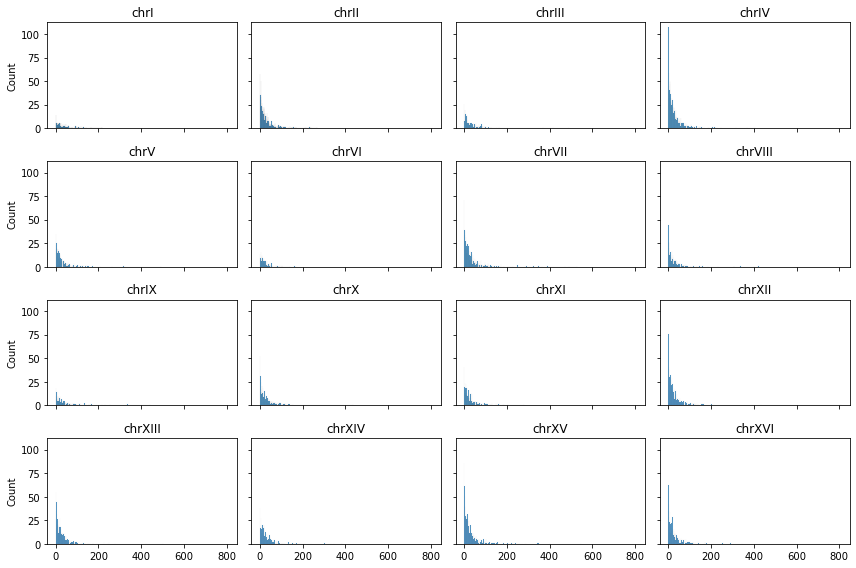

In [151]:
fig, axes = plt.subplots(
    4, 4, figsize=(12, 8), facecolor="w", layout="tight", sharex=True, sharey=True
)
for ax, (k, peaks) in zip(axes.flatten(), peaks_dict.items()):
    if k != "Mmmyco":
        sns.histplot(np.diff(peaks, axis=-1).squeeze(), discrete=True, ax=ax)
        ax.set_title(k)

In [169]:
for k, peaks in peaks_dict.items():
    lengths = np.diff(peaks, axis=-1).squeeze()
    print(k, np.sum(lengths > 200))
    print(peaks[lengths > 200])

chrI 4
[[  1463   1777]
 [ 26623  26850]
 [231100 231351]
 [240129 240425]]
chrII 3
[[  7288   7613]
 [293072 293375]
 [811773 812075]]
chrIII 1
[[342226 342522]]
chrIV 5
[[  12597   12906]
 [ 469766  470068]
 [1098624 1098943]
 [1167102 1167421]
 [1527755 1528057]]
chrV 2
[[454826 455152]
 [467779 468110]]
chrVI 1
[[11627 11938]]
chrVII 2
[[  93421   93739]
 [1083726 1084022]]
chrVIII 0
[]
chrIX 0
[]
chrX 4
[[199323 199643]
 [203370 203696]
 [742531 742855]
 [743659 743971]]
chrXI 2
[[673421 673746]
 [675966 676283]]
chrXII 5
[[  36480   36819]
 [  37658   37977]
 [ 354445  354651]
 [ 484941  485270]
 [1088515 1088733]]
chrXIII 2
[[914593 914995]
 [915025 915355]]
chrXIV 8
[[ 13087  13405]
 [423233 423525]
 [559698 560025]
 [600440 600689]
 [725666 725959]
 [753359 753684]
 [769394 769720]
 [771205 771518]]
chrXV 4
[[  69084   69324]
 [ 428437  428765]
 [ 866739  867037]
 [1084718 1085014]]
chrXVI 3
[[296259 296578]
 [477607 477869]
 [770804 771009]]
Mmmyco 0
[]


In [10]:
with np.load("/home/alex/shared_folder/SCerevisiae/data/labels_myco_nuc.npz") as f:
    labels_nuc = {k: f[k] for k in f.keys()}
with np.load(
    "/home/alex/shared_folder/SCerevisiae/data/GSE217022/labels_myco_pol_ratio.npz"
) as f:
    labels_pol = {k: f[k] for k in f.keys()}
with np.load(
    "/home/alex/shared_folder/SCerevisiae/data/GSE217022/labels_myco_coh_ratio.npz"
) as f:
    labels_coh = {k: f[k] for k in f.keys()}

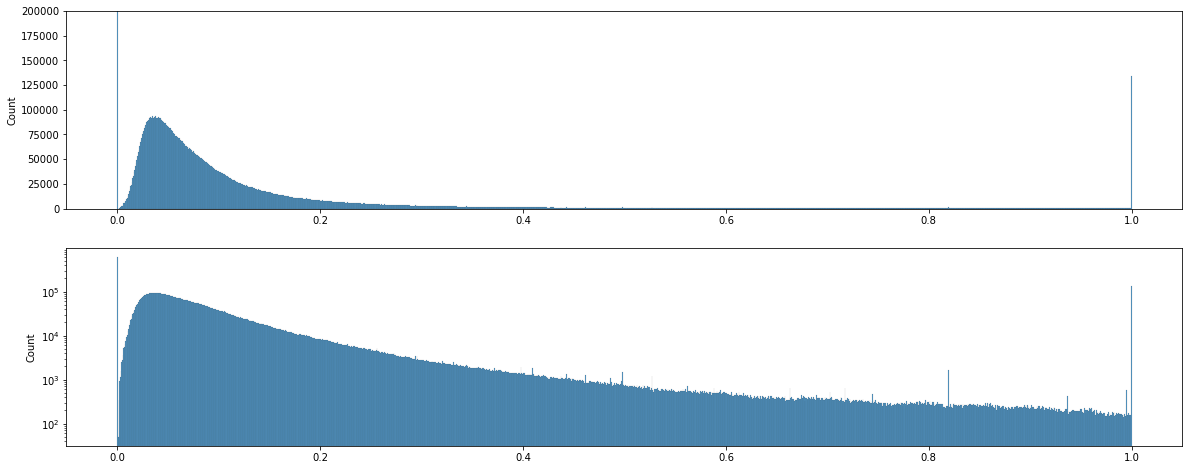

In [25]:
fig, axes = plt.subplots(2, 1, figsize=(20, 8))
all_values = np.concatenate(list(labels_pol.values()))
sns.histplot(all_values, ax=axes[0])
sns.histplot(all_values, ax=axes[1])
axes[0].set_ylim(top=200000)
axes[1].set_yscale("log")

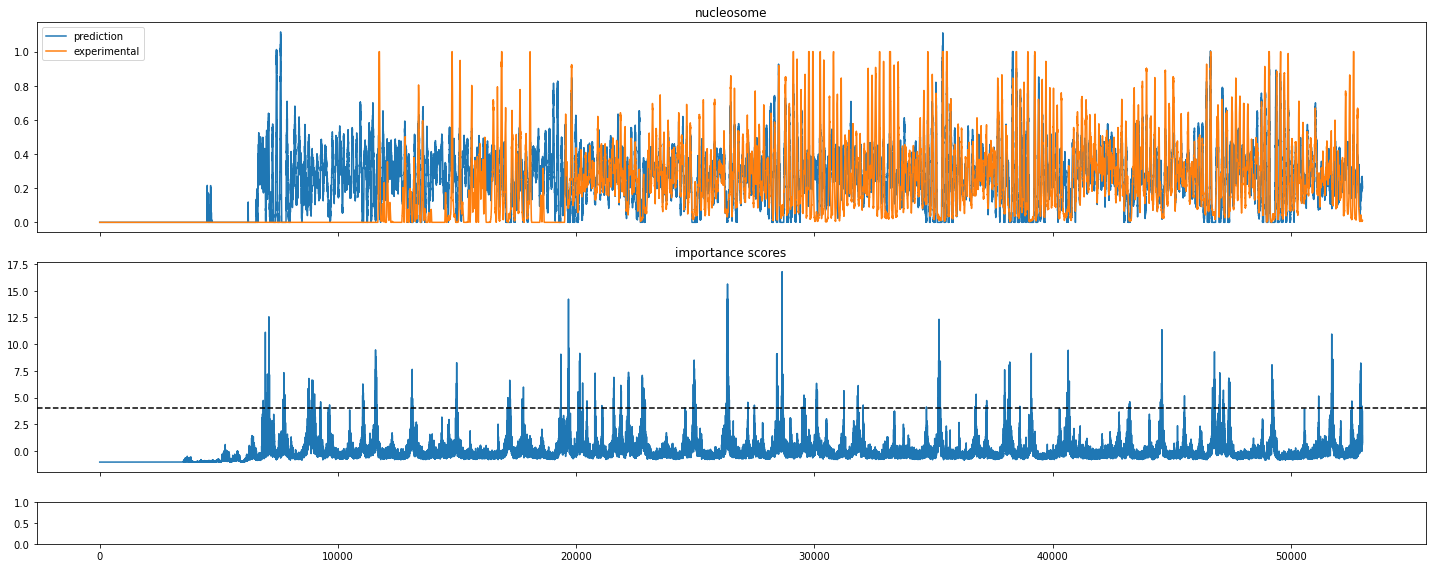

In [12]:
chrom = "chrXVI"
start = 0
stop = start + 53000
fig, axes = plt.subplots(
    3,
    1,
    figsize=(20, 8),
    facecolor="w",
    layout="tight",
    sharex=True,
    gridspec_kw={"height_ratios": [5, 5, 1]},
)
axes[0].set_title("nucleosome")
axes[0].plot(np.arange(start, stop), preds_nuc[chrom][start:stop], label="prediction")
axes[0].plot(
    np.arange(start, stop), labels_nuc[chrom][start:stop], label="experimental"
)
axes[0].legend()
axes[1].set_title("importance scores")
axes[1].plot(
    np.arange(start, stop), z_score_sumgrads[chrom][start:stop], label="saliency"
)
axes[1].axhline(4, color="k", linestyle="--")
# adding mutascores
# ax = axes[1].twinx()
# ax.plot(
#     np.arange(start, stop),
#     mutascores.mean(axis=-1)[start - 10000 : stop - 10000],
#     label="mutasome",
#     color=colors[1],
# )
# han, lab = plot_utils.add_legend([axes[1], ax])
# axes[1].legend(han, lab)
if stop - start < 1000:
    lm.Logo(
        pd.DataFrame(
            one_hots_myco[chrom][start:stop],
            columns=list("ACGT"),
            index=np.arange(start, stop),
        ),
        ax=axes[2],
    )

In [82]:
peaks_dict["chrIV"][
    (peaks_dict["chrIV"][:, 0] > 469000) & (peaks_dict["chrIV"][:, 1] < 472000)
]

array([[469587, 469639],
       [469766, 470068],
       [470912, 471042],
       [471790, 471898]])

In [56]:
with pyBigWig.open(
    "/home/alex/shared_folder/SCerevisiae/data/mutasome_scerevisiae.bw"
) as bw:
    mutasome = {k: bw.values(k, 0, -1, numpy=True) for k in bw.chroms()}

In [61]:
{k: len(v) for k, v in mutasome.items()}

{'chrI': 230218,
 'chrII': 813184,
 'chrIII': 316620,
 'chrIV': 1531933,
 'chrV': 576874,
 'chrVI': 270161,
 'chrVII': 1090940,
 'chrVIII': 562643,
 'chrIX': 439888,
 'chrX': 745751,
 'chrXI': 666816,
 'chrXII': 1078177,
 'chrXIII': 924431,
 'chrXIV': 784333,
 'chrXV': 1091291,
 'chrXVI': 948066}

In [62]:
{k: len(v) for k, v in one_hots_myco.items()}

{'chrI': 245675,
 'chrII': 818518,
 'chrIII': 347597,
 'chrIV': 1548464,
 'chrV': 590080,
 'chrVI': 271173,
 'chrVII': 1090383,
 'chrVIII': 580970,
 'chrIX': 429631,
 'chrX': 751537,
 'chrXI': 678555,
 'chrXII': 1103351,
 'chrXIII': 932757,
 'chrXIV': 777478,
 'chrXV': 1091404,
 'chrXVI': 932221,
 'Mmmyco': 1222199}

In [52]:
# np.savez(
#     "/home/alex/shared_folder/SCerevisiae/results/model_myco_nuc_2/one_hots_chrI.npz",
#     np.transpose(one_hots, [0, 2, 1]),
# )
# np.savez(
#     "/home/alex/shared_folder/SCerevisiae/results/model_myco_nuc_2/saliency_chrI.npz",
#     np.transpose(full_grads, [0, 2, 1]),
# )
# np.savez(
#     "/home/alex/shared_folder/SCerevisiae/results/model_myco_nuc_2/saliency_chrI_abs.npz",
#     np.transpose(np.abs(full_grads), [0, 2, 1]),
# )

In [53]:
with np.load(
    "/home/alex/shared_folder/SCerevisiae/results/model_myco_nuc_2/saliency_chrI.npz"
) as f:
    print(f["arr_0"].shape)
with np.load(
    "/home/alex/shared_folder/SCerevisiae/results/model_myco_nuc_2/saliency_chrI_abs.npz"
) as f:
    print(f["arr_0"].shape)

(243675, 4, 2001)
(243675, 4, 2001)


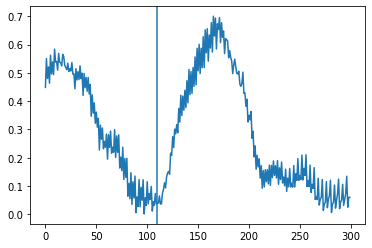

In [12]:
start = 11_300
stop = start + 300
plt.plot(preds_nuc["chrXVI"][start:stop])
plt.axvline(x=110)

In [50]:
allseqs = []
with h5py.File(
    "/home/alex/shared_folder/SCerevisiae/results/model_myco_nuc_2/modisco_results_chrI.h5",
    "r",
) as f:
    titles = list(f.keys())
    print(titles)
    for signkey in ["neg_patterns", "pos_patterns"]:
        if signkey in f.keys():
            # Show important file info
            print(
                f"{signkey}: {len(f[signkey])}",
                [v["seqlets"]["n_seqlets"][0] for v in f[signkey].values()],
            )
            # Check equivalences in file
            for patkey, pat in f[signkey].items():
                if list(pat.keys())[-1] != "subpattern_0":
                    n_subpatterns = int(list(pat.keys())[-1][11:]) + 1
                    print(
                        f"\t{patkey} subpatterns: {n_subpatterns}",
                        [
                            v["seqlets"]["n_seqlets"][0]
                            for v in list(pat.values())[-n_subpatterns:]
                        ],
                    )
            # Save sequences by file and sign
            seqs = {}
            for patkey in f[signkey].keys():
                seqs[patkey] = pd.DataFrame(
                    f[signkey][patkey]["sequence"][:], columns=list("ATCG")
                )
            seqs = dict(sorted(seqs.items(), key=lambda x: int(x[0][8:])))
            if len(seqs) != 0:
                allseqs.append(seqs)

['neg_patterns', 'pos_patterns']
neg_patterns: 23 [82, 79, 46, 45, 45, 38, 35, 34, 34, 33, 32, 27, 77, 23, 22, 20, 76, 76, 75, 53, 51, 47, 47]
	pattern_0 subpatterns: 7 [17, 15, 14, 11, 10, 8, 7]
	pattern_1 subpatterns: 4 [22, 20, 20, 17]
	pattern_2 subpatterns: 4 [35, 32, 8, 2]
	pattern_3 subpatterns: 6 [20, 19, 17, 16, 2, 2]
	pattern_4 subpatterns: 4 [31, 21, 18, 6]
	pattern_5 subpatterns: 5 [26, 16, 15, 9, 9]
	pattern_6 subpatterns: 3 [33, 13, 7]
pos_patterns: 34 [102, 94, 45, 42, 42, 40, 38, 37, 36, 35, 35, 34, 74, 32, 30, 28, 28, 27, 26, 25, 24, 23, 22, 63, 22, 20, 20, 20, 61, 61, 47, 46, 46, 45]
	pattern_0 subpatterns: 8 [19, 17, 14, 13, 12, 12, 9, 6]
	pattern_1 subpatterns: 10 [18, 16, 13, 9, 8, 8, 6, 6, 5, 5]
	pattern_2 subpatterns: 6 [20, 15, 15, 10, 7, 7]
	pattern_3 subpatterns: 4 [24, 17, 15, 7]
	pattern_4 subpatterns: 4 [24, 23, 8, 6]
	pattern_5 subpatterns: 4 [18, 16, 15, 12]


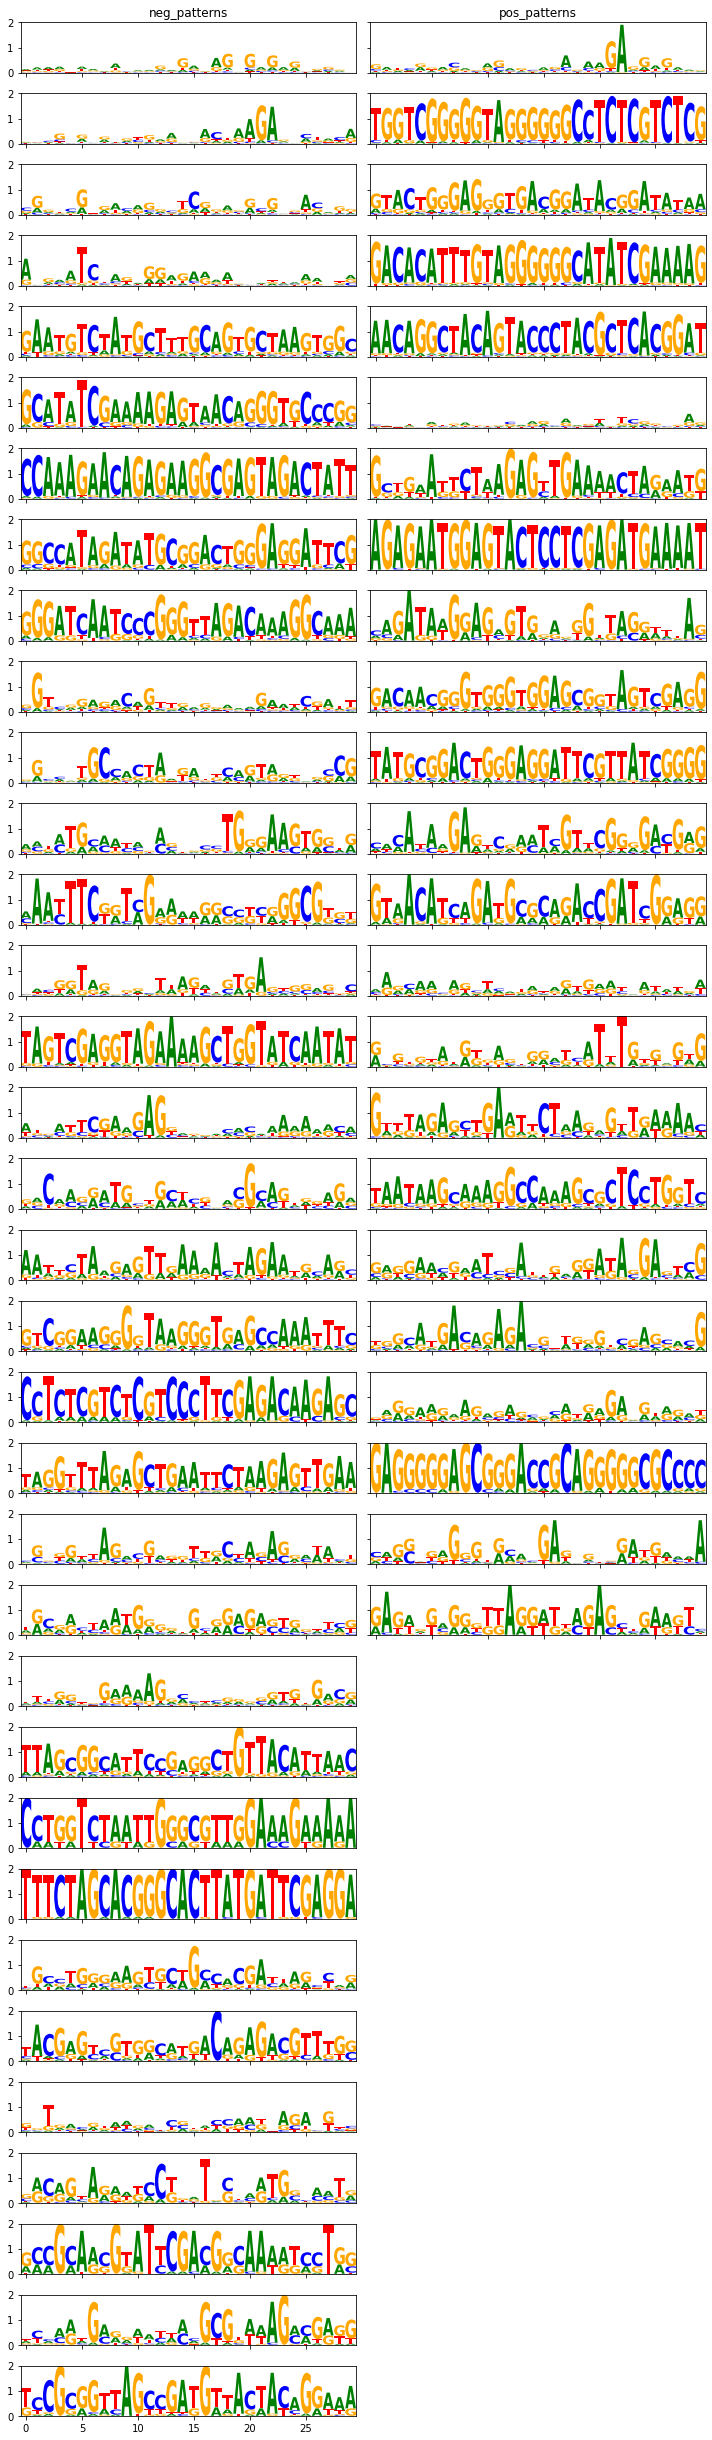

In [49]:
max_len = max((len(v) for v in allseqs))
fig, axes = plt.subplots(
    max_len,
    2,
    figsize=(5 * len(allseqs), max_len),
    facecolor="w",
    layout="tight",
    sharex=True,
    sharey=True,
)
for j, seqs in enumerate(allseqs):
    axes[0, j].set_title(titles[j])
    for i, (patkey, seq) in enumerate(seqs.items()):
        if i >= max_len:
            print(f"Exceeding max_len in column {j}")
            break
        pwm = seq * np.log2(seq)
        pwm.fillna(0, inplace=True)
        lm.Logo(seq.multiply(2 + pwm.sum(axis=1), axis=0), ax=axes[i, j])
        axes[i, j].set_ylim((0, 2))
    for k in range(i + 1, max_len):
        axes[k, j].set_axis_off()